In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import scipy as sci

# Target parameters

In [2]:
rho = 1.225 # density of air at sea level
M_des = 0.45 # desired Mach number
a = 343 # speed of sound, sea level, m/s
a_nm = 343*1.944 # speed of sound, sea level, knots
P = 101300 # Pressure at sea level, pascals

# Weight Estimation

In [3]:
teu_des = 60
mass_teu = 20320 # max mass per teu, kg, https://de.wikipedia.org/wiki/Twenty-foot_Equivalent_Unit
weight_load = np.inner(teu_des, mass_teu)*2.205 # payload weight, lbm
print(weight_load)

2688336.0


Range and Engine Parameters

In [30]:
target_range = 6800 # nm
ld_des = 33
tsfc = 0.478; # RR Trent XWB-97, Airbus A350, lbm/lbf/h, https://www.easa.europa.eu/sites/default/files/dfu/EASA%20E111%20TCDS%20issue%2012_Trent%20XWB.pdf

Weight Fractions

In [31]:
wf_cruise = np.exp(-target_range/M_des/ld_des/a_nm*tsfc) # cruise weight fraction
wf = np.array([0.9725, 1.0065-0.0325*M_des, wf_cruise, 0.9725]) # weight fractions for TO, climb, cruise, land

# wf_total = np.prod(wf) # total weight fraction
wf_total = 1 - 0.2363

x, y = sp.symbols('x y')

to_bound = x*(1 - 1.02*x**-0.06)-(1-wf_total)*x-weight_load # take-off bound from lecture notes
w_to = sp.nsolve(to_bound, 500000) # Estimate for Take-Off Weight
print(w_to)

7295356.70877210


# Wing Sizing

In [6]:
clmax = 2.6 # assume cl_max

Plots

<Figure size 640x480 with 0 Axes>

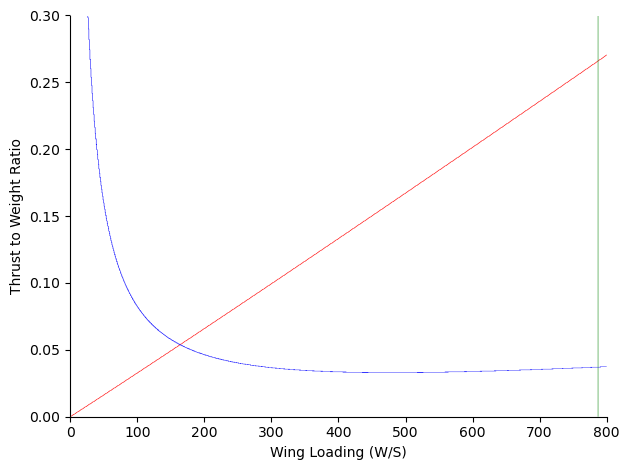

In [32]:
from sympy.plotting import plot, plot3d, PlotGrid
ax = plt.figure()
# Take-Off Bound
takeoff = sp.plot_implicit(sp.Eq(25000 - 20.9*x/(rho/rho)/clmax/y - 69.6*sp.sqrt(x/(rho/rho)/clmax), 0), (x, 0, 800), (y, 0, 0.3), label = 'Takeoff Bound', xlabel = 'Wing Loading (W/S)', ylabel = 'Thrust to Weight Ratio', line_color = 'red', show = False)
# Landing Bound
land = sp.plot_implicit(sp.Eq(25000 - 79.4*(x/(rho/rho)/clmax) - 50/sp.tan(3*np.pi/180), 0),  (x,0, 800), (y, 0, 0.3), label = 'Landing Bound', line_color = 'green',show = False)
takeoff.append(land[0])

alpha_tilde = (P/P)*(1+0.2*M_des**2)**(1.4/0.4) * (1-0.49*np.sqrt(M_des))
cd0 = 0.02 # assume value for Cd_0
k1 = (clmax/ld_des - cd0)/clmax**2 # quick calculation for k1, ignoring k2
q_inf = 0.5*rho*(a*M_des)**2/47.88; # dynamic pressure in lb/ft^2

# we assume beta constant for the entire flight and that beta = weight
# after take-off and climb-out. This is justified as 1) this will be the
# initial state of cruise, so it is the 'least favourable' stage of flight
# for simplicity and 2) this will provide an underestimate for the possible
# flight envelope, which is better than an overestimate for initial design

beta = wf[0]*wf[1]
cruise = sp.plot_implicit(sp.Eq(y - beta/alpha_tilde * ((k1 * (beta/q_inf)*x) + cd0/(beta/q_inf)/x), 0), (x, 0, 800), (y, 0, 0.3), label = 'Cruise Bound', show = False)
takeoff.append(cruise[0])
takeoff.show()

Blue: Cruise Range Bound

Red: Take-Off Distance Bound

Green: Landing Distance Bound

Pick Points

In [33]:
tw = 0.15 # Chosen thrust to weight ratio
ws = 400 # Chosen wing loading
sref = w_to/ws # reference area (ft2)
t0 = w_to*tw # required thrust (lbf)
print(sref*0.305**2)
print(t0)

1696.62639458381
1094303.50631582


# Fuselage Sizing

In [34]:
teu_dim = np.array([6.058, 2.438, 2.591]) # TEU container dimensions, m, l,w,h

vol_fuselage = np.prod(teu_dim)*120/0.305**3 # fuselage volume in ft^3

# consider 2-height, 2-wide stacking, i.e. 4 per row, then
rows1 = teu_des/4
fus_dim1 = np.array([rows1*teu_dim[0], 2*teu_dim[1], 2*teu_dim[2]])
print(fus_dim1)

# now consider stacking 'sideways', such that the long side spans the width of the fuselage
# two per row, stack 2 heigh
rows2 = 40/2
fus_dim2 = np.array([rows2*teu_dim[1], teu_dim[0], 2*teu_dim[2]])
print(fus_dim2)

[90.87   4.876  5.182]
[48.76   6.058  5.182]


# Stabiliser Sizing

In [35]:
# all are in m
ar_des = 6.5
b = (sref * ar_des)**0.5
cref = sref/b # assumed initial value for reference chord. reasonable good estimation as the ekranoplan wing will likely have low taper and little sweep
print(b * 0.305)
print(cref * 0.305)
print(sref*0.305**2)

# all in metres
vh = 0.70 # tail volume, for reference check https://www.researchgate.net/figure/Typical-Values-of-Tail-Volume-Coefficient_fig12_321107730, flying boat
cref = 13.51 # actual main wing reference chord, metres
cref_t = 5.2; # hs reference chord - assume some value based on main wing chord or take from design
x_wing = 20 # location of wing
x_h = 91 # location of hs
l_t = (x_h + cref_t/4)-(x_wing + cref/4) # hs distance to neutral point, assuming quarter chord = aerodynamic centre
sref_t = vh*cref*sref*0.305**2/l_t; # sref of hs in m^2
print(sref_t)

vv = 0.06 # vertical stabiliser volume
cref_vs = 10 # vs reference chord
x_v = 81 # vs location
l_v = (x_v + cref_vs/4)-(x_wing + cref/4) # vs distance to neutral point, assuming quarter chord = aerodynamic centre
sref_v = vv*b*0.305*sref*0.305**2/l_v # sref of vs in m^2
print(sref_v)

105.014625480429
16.1560962277583
1696.62639458381
232.797646829107
177.807561635757


# Compressibility Effects

In [11]:
# we require M_divergence = M_desired
sref_design = 240 # reference area of the actual design
ar = b**2/sref_design # aspect ratio of actual design

para = np.cos(35*np.pi/180)**2*0.11**2*ar # parameter to select an actual clmax from charts
clmax_to = 1.80 # from charts
clmax_l = 2.75 # from charts

# Jet fuel density = 6.77 lb/US gallon: https://www.flyembraer.com/irj/go/km/docs/download_center/Anonymous/Ergonomia/Home%20Page/Documents/APM_195.pdf
jp1_vol = (1-wf_total)*w_to/6.77/264.2; # required jet fuel volume in m^3, compare to design volume